In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.path as mpath
import matplotlib.patches as patches
import matplotlib.cm as cm
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import cartopy.mpl.gridliner as gridliner
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", message="All-NaN slice encountered")
%matplotlib inline
import time
import cftime
import seaborn as sns
from scipy.signal import detrend

In [2]:
plt.rc('font', size=17)          # controls default text sizes
plt.rc('axes', titlesize=17)     # fontsize of the axes title
plt.rc('axes', labelsize=17)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

In [3]:
path1='/Users/thomas/Downloads/ERA5+Nain/Nain'
path2='/Users/thomas/Downloads/ERA5+Nain/ERA5'

In [4]:
file_paths = glob.glob(path2+'/ERA5_*')
data=xr.open_mfdataset(file_paths,  chunks={'time': 24})
t2m=data['t2m']

In [5]:
## coastal areas
nain_lon_min, nain_lon_max =-62, -61 #298.31 W  # -61.69
nain_lat_min, nain_lat_max = 56.5,56.6 #56.54 N

hope_lon_min, hope_lon_max =-61, -60#299.79 W  # -60.21
hope_lat_min, hope_lat_max =55.4,55.5  #55.45 N

post_lon_min, post_lon_max = -59, -58.5#300.23 W  # -59.77
post_lat_min, post_lat_max = 54.9,55 #54.91 N

rigo_lon_min, rigo_lon_max = -58.5, -57 #301.58 W  # -58.42
rigo_lat_min, rigo_lat_max = 54.16,54.3  #54.17 N

In [6]:
nain_lon = -61.69 #298.31 W  # -61.69
nain_lat = 56.54 #56.54 N
nain_TSA_region=t2m.sel(longitude=nain_lon, latitude=nain_lat, method='nearest')
nain_TSA_daily = nain_TSA_region.resample(time='1D').mean()
nain_TSA_daily_celsius=nain_TSA_daily -273.15

In [7]:
# Define the Labrador coast boundaries (replace these with your desired region)
def region(lon_min, lon_max, lat_min, lat_max):

    # Create a mask for Labrador coast 
    mask = ((t2m.latitude >= lat_min) & (t2m.latitude <= lat_max) &
            (t2m.longitude >= lon_min) & (t2m.longitude <= lon_max))

    # Apply the mask to the t2m variable
    t2m_region =t2m.where(mask, drop=True)
    
    t2m_sel= t2m_region.mean(dim=['longitude', 'latitude'])
    t2m_daily = t2m_sel.resample(time='1D').mean()
    t2m_daily_celsius=t2m_daily -273.15
    
    return t2m_daily_celsius

In [8]:
nain_t2m_daily_celsius = region(nain_lon_min, nain_lon_max, nain_lat_min, nain_lat_max)
hope_t2m_daily_celsius = region(hope_lon_min, hope_lon_max, hope_lat_min, hope_lat_max)
post_t2m_daily_celsius = region(post_lon_min, post_lon_max, post_lat_min, post_lat_max)
rigo_t2m_daily_celsius = region(rigo_lon_min, rigo_lon_max, rigo_lat_min, rigo_lat_max)

In [9]:
def ffd (t2m, onset_date, date1, date2, date3, date4):
    t2m_year=t2m.sel(time=slice(onset_date, date4))

    #selecting particular observed dates
    t2m_year_date1=t2m_year.sel(time=slice(onset_date, date1))
    t2m_year_date2=t2m_year.sel(time=slice(onset_date, date2))
    t2m_year_date3=t2m_year.sel(time=slice(onset_date, date3))
    t2m_year_date4=t2m_year.sel(time=slice(onset_date, date4))

    #correct conversion to positive freezing degrees
    t2m_year_date1_fd=t2m_year_date1.where(t2m_year_date1<0,drop=True)*-1
    t2m_year_date2_fd=t2m_year_date2.where(t2m_year_date2<0,drop=True)*-1
    t2m_year_date3_fd=t2m_year_date3.where(t2m_year_date3<0,drop=True)*-1
    t2m_year_date4_fd=t2m_year_date4.where(t2m_year_date4<0,drop=True)*-1

    #calculating the freezing degree days
    t2m_year_date1_fdd=round(t2m_year_date1_fd.sum(dim='time').values.item(), 2)
    t2m_year_date2_fdd=round(t2m_year_date2_fd.sum(dim='time').values.item(), 2)
    t2m_year_date3_fdd=round(t2m_year_date3_fd.sum(dim='time').values.item(), 2)
    t2m_year_date4_fdd=round(t2m_year_date4_fd.sum(dim='time').values.item(), 2)
    
    return [t2m_year_date1_fdd, t2m_year_date2_fdd, t2m_year_date3_fdd, t2m_year_date4_fdd]

In [10]:
#nain
nain_2009_fdd = ffd(nain_t2m_daily_celsius, '2008-12-08', '2009-04-03', '2009-04-18', '2009-05-01', '2009-05-23')
nain_2010_fdd = ffd(nain_t2m_daily_celsius, '2009-12-21', '2010-02-26', '2010-03-12', '2010-03-26', '2010-04-16')
nain_2011_fdd = ffd(nain_t2m_daily_celsius, '2010-12-27', '2011-02-26', '2011-03-11', '2011-03-29', '2011-04-05')
nain_2013_fdd = ffd(nain_t2m_daily_celsius, '2012-12-16', '2013-02-14', '2013-02-27', '2013-03-19', '2013-04-26')
nain_2015_fdd = ffd(nain_t2m_daily_celsius, '2014-12-07', '2015-01-30', '2015-02-26', '2015-03-26', '2015-04-28')
nain_2016_fdd = ffd(nain_t2m_daily_celsius, '2015-12-19', '2016-02-19', '2016-03-31', '2016-04-22', '2016-05-05')
nain_2017_fdd = ffd(nain_t2m_daily_celsius, '2016-12-19', '2017-02-23', '2017-03-30', '2017-04-28', '2017-05-16')
nain_2018_fdd = ffd(nain_t2m_daily_celsius, '2017-12-25', '2018-02-28', '2018-03-28', '2018-04-29', '2018-05-19')
nain_2019_fdd = ffd(nain_t2m_daily_celsius, '2018-12-03', '2019-02-04', '2019-02-25', '2019-03-10', '2019-03-28')
nain_2020_fdd = ffd(nain_t2m_daily_celsius, '2019-12-16', '2020-04-12', '2020-04-24', '2020-04-30', '2020-05-11')
nain_2021_fdd = ffd(nain_t2m_daily_celsius, '2020-12-01', '2021-02-21', '2021-03-11', '2021-03-31', '2021-04-22')
nain_2022_fdd = ffd(nain_t2m_daily_celsius, '2021-12-06', '2022-02-26', '2022-03-28', '2022-04-24', '2022-05-16')
nain_2023_fdd = ffd(nain_t2m_daily_celsius, '2022-12-12', '2023-02-14', '2023-03-13', '2023-03-28', '2023-04-24')

#hope
hope_2009_fdd = ffd(hope_t2m_daily_celsius, '2008-12-08', '2009-04-03', '2009-04-18', '2009-05-01', '2009-05-23')
hope_2010_fdd = ffd(hope_t2m_daily_celsius, '2009-12-21', '2010-02-26', '2010-03-12', '2010-03-26', '2010-04-16')
hope_2011_fdd = ffd(hope_t2m_daily_celsius, '2010-12-27', '2011-02-26', '2011-03-11', '2011-03-29', '2011-04-05')
hope_2013_fdd = ffd(hope_t2m_daily_celsius, '2012-12-16', '2013-02-14', '2013-02-27', '2013-03-19', '2013-04-26')
hope_2015_fdd = ffd(hope_t2m_daily_celsius, '2014-12-07', '2015-01-30', '2015-02-26', '2015-03-26', '2015-04-28')
hope_2016_fdd = ffd(hope_t2m_daily_celsius, '2015-12-19', '2016-02-19', '2016-03-31', '2016-04-22', '2016-05-05')
hope_2017_fdd = ffd(hope_t2m_daily_celsius, '2016-12-19', '2017-02-23', '2017-03-30', '2017-04-28', '2017-05-16')
hope_2018_fdd = ffd(hope_t2m_daily_celsius, '2017-12-25', '2018-02-28', '2018-03-28', '2018-04-29', '2018-05-19')
hope_2019_fdd = ffd(hope_t2m_daily_celsius, '2018-12-03', '2019-02-04', '2019-02-25', '2019-03-10', '2019-03-28')
hope_2020_fdd = ffd(hope_t2m_daily_celsius, '2019-12-16', '2020-04-12', '2020-04-24', '2020-04-30', '2020-05-11')
hope_2021_fdd = ffd(hope_t2m_daily_celsius, '2020-12-01', '2021-02-21', '2021-03-11', '2021-03-31', '2021-04-22')
hope_2022_fdd = ffd(hope_t2m_daily_celsius, '2021-12-06', '2022-02-26', '2022-03-28', '2022-04-24', '2022-05-16')
hope_2023_fdd = ffd(hope_t2m_daily_celsius, '2022-12-12', '2023-02-14', '2023-03-13', '2023-03-28', '2023-04-24')

In [11]:
def hice_from_fdd (fdd_data):
    
    day2sec = 24 * 60 * 60
    hs = 0.05
    #FDD = np.arange(0, 2501, 1)  # Create array from 0 to 2500 with step 1
    Ki = 2.0
    Ks = 0.2
    rhoi = 917
    Lf = 3.35e5
    a = Ks / 2
    b = Ki * hs
   

    # Calculate h using quadratic formula
    

    thickness_results = []

    for fdd in fdd_data:
        # Convert FDD to consistent units (days to seconds)
        c = -Ki * Ks / (rhoi * Lf) * fdd * day2sec  # Convert days to seconds

        # Calculate ice thickness
        h = (-b + np.sqrt(b**2 - 4 * a * c)) / (2 * a)
        #h = round(np.sqrt((2 * Ki * FDD_in_seconds) / (rho_ice * Lf)),2)

        # Store the thickness result in the dictionary
        thickness_results.append(h)
        
    return thickness_results

In [12]:
def h_var(fdd):
    day2sec = 24 * 60 * 60
    hs = 0.05
    #FDD = np.arange(0, 2501, 1)  # Create array from 0 to 2500 with step 1
    Ki = 2.0
    Ks = 0.2
    rhoi = 917
    Lf = 3.35e5
    a = Ks / 2
    b = Ki * hs
    c = -Ki * Ks / (rhoi * Lf) * fdd * day2sec
    h = (-b + np.sqrt(b**2 - 4 * a * c)) / (2 * a)
    return h

In [13]:
def hice_from_fdd1 (fdd_data):
    
    # Given constants
    Ki =0.73 # W/(m*K)
    rho_ice = 917  # kg/m^3
    Lf = 334000  # J/kg
    # Calculate ice thickness for each year
    thickness_results = []

    for fdd in fdd_data:
        # Convert FDD to consistent units (days to seconds)
        FDD_in_seconds = fdd * 86400  # Convert days to seconds

        # Calculate ice thickness
        h = round(np.sqrt((2 * Ki * FDD_in_seconds) / (rho_ice * Lf)),2)

        # Store the thickness result in the dictionary
        thickness_results.append(h)
        
    return thickness_results

In [14]:
def hice_from_fdd2 (fdd_data):
    
    # Given constants
    Ki =0.95 # W/(m*K)
    rho_ice = 917  # kg/m^3
    Lf = 334000  # J/kg
    # Calculate ice thickness for each year
    thickness_results = []

    for fdd in fdd_data:
        # Convert FDD to consistent units (days to seconds)
        FDD_in_seconds = fdd * 86400  # Convert days to seconds

        # Calculate ice thickness
        h = round(np.sqrt((2 * Ki * FDD_in_seconds) / (rho_ice * Lf)),2)

        # Store the thickness result in the dictionary
        thickness_results.append(h)
        
    return thickness_results

In [15]:
#nain
nain_2009_hice = hice_from_fdd(nain_2009_fdd)
nain_2010_hice = hice_from_fdd(nain_2010_fdd)
nain_2011_hice = hice_from_fdd(nain_2011_fdd)
nain_2013_hice = hice_from_fdd(nain_2013_fdd)
nain_2015_hice = hice_from_fdd(nain_2015_fdd)
nain_2016_hice = hice_from_fdd(nain_2016_fdd)
nain_2017_hice = hice_from_fdd(nain_2017_fdd)
nain_2018_hice = hice_from_fdd(nain_2018_fdd)
nain_2019_hice = hice_from_fdd(nain_2019_fdd)
nain_2020_hice = hice_from_fdd(nain_2020_fdd)
nain_2021_hice = hice_from_fdd(nain_2021_fdd)
nain_2022_hice = hice_from_fdd(nain_2022_fdd)
nain_2023_hice = hice_from_fdd(nain_2023_fdd)

In [16]:
#nain
nain_2009_hice1 = hice_from_fdd1(nain_2009_fdd)
nain_2010_hice1 = hice_from_fdd1(nain_2010_fdd)
nain_2011_hice1 = hice_from_fdd1(nain_2011_fdd)
nain_2013_hice1 = hice_from_fdd1(nain_2013_fdd)
nain_2015_hice1 = hice_from_fdd1(nain_2015_fdd)
nain_2016_hice1 = hice_from_fdd1(nain_2016_fdd)
nain_2017_hice1 = hice_from_fdd1(nain_2017_fdd)
nain_2018_hice1 = hice_from_fdd1(nain_2018_fdd)
nain_2019_hice1 = hice_from_fdd1(nain_2019_fdd)
nain_2020_hice1 = hice_from_fdd1(nain_2020_fdd)
nain_2021_hice1 = hice_from_fdd1(nain_2021_fdd)
nain_2022_hice1 = hice_from_fdd1(nain_2022_fdd)
nain_2023_hice1 = hice_from_fdd1(nain_2023_fdd)

In [17]:
#nain
nain_2009_hice2 = hice_from_fdd2(nain_2009_fdd)
nain_2010_hice2 = hice_from_fdd2(nain_2010_fdd)
nain_2011_hice2 = hice_from_fdd2(nain_2011_fdd)
nain_2013_hice2 = hice_from_fdd2(nain_2013_fdd)
nain_2015_hice2 = hice_from_fdd2(nain_2015_fdd)
nain_2016_hice2 = hice_from_fdd2(nain_2016_fdd)
nain_2017_hice2 = hice_from_fdd2(nain_2017_fdd)
nain_2018_hice2 = hice_from_fdd2(nain_2018_fdd)
nain_2019_hice2 = hice_from_fdd2(nain_2019_fdd)
nain_2020_hice2 = hice_from_fdd2(nain_2020_fdd)
nain_2021_hice2 = hice_from_fdd2(nain_2021_fdd)
nain_2022_hice2 = hice_from_fdd2(nain_2022_fdd)
nain_2023_hice2 = hice_from_fdd2(nain_2023_fdd)

In [18]:
#Nain observational data

sat = pd.read_excel(path1+'/Satosoak-2009_2023.xlsx')
tak = pd.read_excel(path1+'/Taktok-2009_2023.xlsx')


In [19]:
sat = sat[['Year', 'Month', 'Day', 'Hice_Mean']]
tak = tak[['Year', 'Month', 'Day', 'Hice_Mean']]

In [20]:
# Calculate the daily averages for each year
sat_daily_averages = sat.groupby(['Year', 'Month', 'Day'])['Hice_Mean'].mean().reset_index()
tak_daily_averages = tak.groupby(['Year', 'Month', 'Day'])['Hice_Mean'].mean().reset_index()

In [21]:
sat_daily_averages['date'] = pd.to_datetime(sat_daily_averages[['Year','Month', 'Day']])
tak_daily_averages['date'] = pd.to_datetime(tak_daily_averages[['Year','Month', 'Day']])

In [22]:
#hope
dates=['2009-04-03', '2009-04-18', '2009-05-01', '2009-05-23','2010-02-26', '2010-03-12', '2010-03-26', '2010-04-16',
 '2011-02-26', '2011-03-11', '2011-03-29', '2011-04-05','2013-02-14', '2013-02-27', '2013-03-19', '2013-04-26',
 '2015-01-30', '2015-02-26', '2015-03-26', '2015-04-28','2016-02-19', '2016-03-31', '2016-04-22', '2016-05-05',
 '2017-02-23', '2017-03-30', '2017-04-28', '2017-05-16','2018-02-28', '2018-03-28', '2018-04-29', '2018-05-19',
 '2019-02-04', '2019-02-25', '2019-03-10', '2019-03-28','2020-04-12', '2020-04-24', '2020-04-30', '2020-05-11',
 '2021-02-21', '2021-03-11', '2021-03-31', '2021-04-22','2022-02-26', '2022-03-28', '2022-04-24', '2022-05-16',
 '2023-02-14', '2023-03-13', '2023-03-28', '2023-04-24']


dates_to_select = pd.to_datetime(dates)

# Filter dataframe for the specified dates
filtered_sat_daily_averages = sat_daily_averages[sat_daily_averages['date'].isin(dates_to_select)]
filtered_tak_daily_averages = tak_daily_averages[tak_daily_averages['date'].isin(dates_to_select)]

In [23]:
def sat_yearly_variable(year):
    return round((filtered_sat_daily_averages[filtered_sat_daily_averages['Year'] == year]['Hice_Mean']*0.01),2).tolist()

def tak_yearly_variable(year):
    return round((filtered_tak_daily_averages[filtered_tak_daily_averages['Year'] == year]['Hice_Mean']*0.01),2).tolist()


# Create variables for each year
sat_2009_hice = sat_yearly_variable(2009)
sat_2010_hice = sat_yearly_variable(2010)
sat_2011_hice = sat_yearly_variable(2011)
sat_2013_hice = sat_yearly_variable(2013)
sat_2015_hice = sat_yearly_variable(2015)
sat_2016_hice = sat_yearly_variable(2016)
sat_2017_hice = sat_yearly_variable(2017)
sat_2018_hice = sat_yearly_variable(2018)
sat_2019_hice = sat_yearly_variable(2019)
sat_2020_hice = sat_yearly_variable(2020)
sat_2021_hice = sat_yearly_variable(2021)
sat_2022_hice = sat_yearly_variable(2022)
sat_2023_hice = sat_yearly_variable(2023)


# Create variables for each year
tak_2009_hice = tak_yearly_variable(2009)
tak_2010_hice = tak_yearly_variable(2010)
tak_2011_hice = tak_yearly_variable(2011)
tak_2013_hice = tak_yearly_variable(2013)
tak_2015_hice = tak_yearly_variable(2015)
tak_2016_hice = tak_yearly_variable(2016)
tak_2017_hice = tak_yearly_variable(2017)
tak_2018_hice = tak_yearly_variable(2018)
tak_2019_hice = tak_yearly_variable(2019)
tak_2020_hice = tak_yearly_variable(2020)
tak_2021_hice = tak_yearly_variable(2021)
tak_2022_hice = tak_yearly_variable(2022)
tak_2023_hice = tak_yearly_variable(2023)

### Visualization

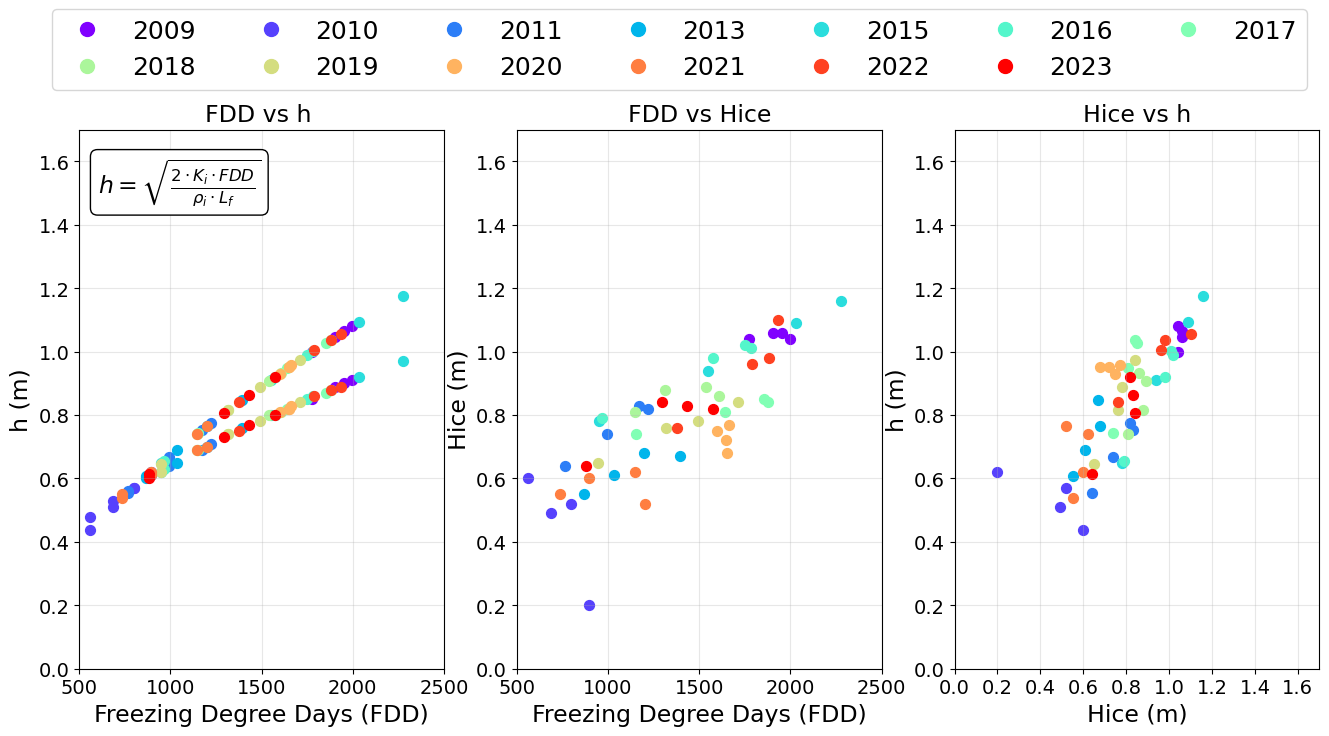

In [24]:
years = [2009, 2010, 2011, 2013, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

fdd_vars = [
    nain_2009_fdd, nain_2010_fdd, nain_2011_fdd, nain_2013_fdd,
    nain_2015_fdd, nain_2016_fdd, nain_2017_fdd, nain_2018_fdd,
    nain_2019_fdd, nain_2020_fdd, nain_2021_fdd, nain_2022_fdd, 
    nain_2023_fdd
]

h_vars = [
    nain_2009_hice, nain_2010_hice, nain_2011_hice, nain_2013_hice,
    nain_2015_hice, nain_2016_hice, nain_2017_hice, nain_2018_hice,
    nain_2019_hice, nain_2020_hice, nain_2021_hice, nain_2022_hice, 
    nain_2023_hice
]

h_vars1 = [
    nain_2009_hice1, nain_2010_hice1, nain_2011_hice1, nain_2013_hice1,
    nain_2015_hice1, nain_2016_hice1, nain_2017_hice1, nain_2018_hice1,
    nain_2019_hice1, nain_2020_hice1, nain_2021_hice1, nain_2022_hice1, 
    nain_2023_hice1
]

hice_vars = [
    sat_2009_hice, sat_2010_hice, sat_2011_hice, sat_2013_hice,
    sat_2015_hice, sat_2016_hice, sat_2017_hice, sat_2018_hice,
    sat_2019_hice, sat_2020_hice, sat_2021_hice, sat_2022_hice, 
    sat_2023_hice
]

# Colors for each year
colors = plt.cm.rainbow(np.linspace(0, 1, len(years)))

# Increase figure size and adjust layout
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 7))

# Plot for h_vars
for year, fdd, h, h1, color in zip(years, fdd_vars, h_vars,h_vars1 ,colors):
    ax1.scatter(fdd, h, label=f'{year}', color=color, s=50)
    ax1.scatter(fdd, h1, label=f'{year}', color=color, s=50) # Increased point size
ax1.set_title('FDD vs h ')
ax1.set_ylabel('h (m)')
ax1.set_xlabel('Freezing Degree Days (FDD)')
ax1.grid(alpha=0.3)
ax1.set_xticks([500, 1000,  1500, 2000, 2500])
ax1.set_ylim(0,1.7)
ax1.set_xlim(500,2500)

# Add the formula to the first panel
formula_text = r'$h = \sqrt{\frac{2 \cdot K_i \cdot FDD}{\rho_{i} \cdot L_f}}$'
ax1.text(0.05, 0.95, formula_text, transform=ax1.transAxes, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

# Plot for hice_vars
for year, fdd, hice, color in zip(years, fdd_vars, hice_vars, colors):
    ax2.scatter(fdd, hice, label=f'{year}', color=color, s=50)
    #ax2.scatter(np.sqrt(2*Ki*fdd/(rho_ice*Lf)), hice, label=f'{year}', color=color, s=50)
    #ax2.scatter( hice, h, label=f'{year}', color=color, s=50)# Increased point size
ax2.set_title('FDD vs Hice')
ax2.set_xlabel('Freezing Degree Days (FDD)')
ax2.set_ylabel('Hice (m)')
#ax2.set_xlim(0,1.6)
ax2.set_ylim(0,1.7)
ax2.set_xlim(500,2500)
ax2.set_xticks([500, 1000,  1500, 2000, 2500])
ax2.grid(alpha=0.3)

# Plot for hice_vars
for year, hice, h, color in zip(years,hice_vars, h_vars, colors):
    ax3.scatter(hice, h, label=f'{year}', color=color, s=50)
ax3.set_title('Hice vs h')
ax3.set_xlabel('Hice (m)')
ax3.set_ylabel('h (m)')
ax3.set_xlim(0,1.7)
ax3.set_ylim(0,1.7)
ax3.set_xticks([0,0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6])


ax3.grid(alpha=0.3)

ncol=7
year_handles = []
for col in range(ncol):
    for row in range(len(years) // ncol + 1):
        index = col + row * ncol
        if index < len(years):
            year_handles.append(plt.Line2D([0], [0], color=colors[index], linestyle=None,
                                           marker='o', markersize=10, lw=0, label=str(years[index])))

# Adding horizontal legend for years
year_legend = fig.legend(handles=year_handles, loc='upper center', bbox_to_anchor=(0.5, 1.07), ncol=ncol, frameon=True)

# Save and show plot
plt.tight_layout(rect=[0, 0, -0.5, 0.95])
plt.savefig('FDD_h_HICE.jpg', dpi=500, bbox_inches='tight')
plt.show()

### Best Fit

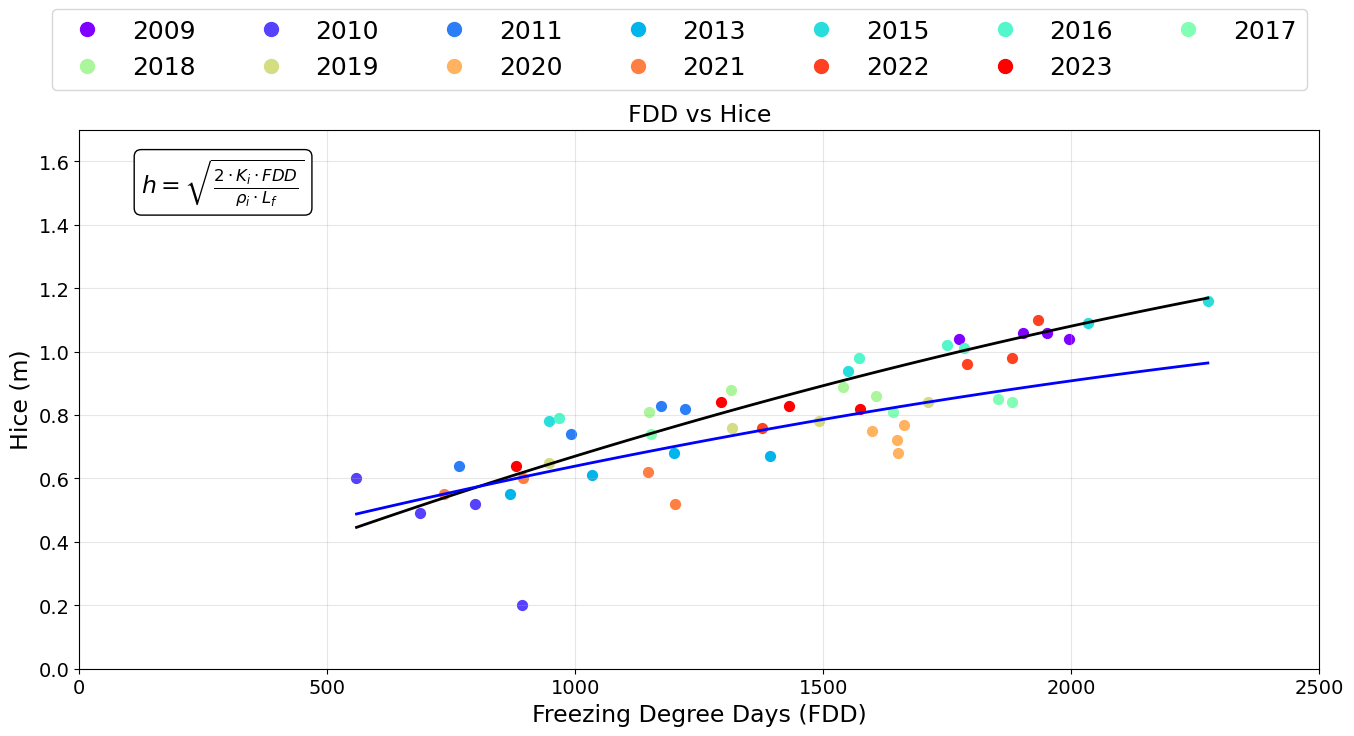

In [25]:
years = [2009, 2010, 2011, 2013, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

fdd_vars = [
    nain_2009_fdd, nain_2010_fdd, nain_2011_fdd, nain_2013_fdd,
    nain_2015_fdd, nain_2016_fdd, nain_2017_fdd, nain_2018_fdd,
    nain_2019_fdd, nain_2020_fdd, nain_2021_fdd, nain_2022_fdd, 
    nain_2023_fdd
]

h_vars = [
    nain_2009_hice, nain_2010_hice, nain_2011_hice, nain_2013_hice,
    nain_2015_hice, nain_2016_hice, nain_2017_hice, nain_2018_hice,
    nain_2019_hice, nain_2020_hice, nain_2021_hice, nain_2022_hice, 
    nain_2023_hice
]

h_vars1 = [
    nain_2009_hice1, nain_2010_hice1, nain_2011_hice1, nain_2013_hice1,
    nain_2015_hice1, nain_2016_hice1, nain_2017_hice1, nain_2018_hice1,
    nain_2019_hice1, nain_2020_hice1, nain_2021_hice1, nain_2022_hice1, 
    nain_2023_hice1
]

hice_vars = [
    sat_2009_hice, sat_2010_hice, sat_2011_hice, sat_2013_hice,
    sat_2015_hice, sat_2016_hice, sat_2017_hice, sat_2018_hice,
    sat_2019_hice, sat_2020_hice, sat_2021_hice, sat_2022_hice, 
    sat_2023_hice
]

# Colors for each year
colors = plt.cm.rainbow(np.linspace(0, 1, len(years)))

# Increase figure size and adjust layout
fig, (ax2) = plt.subplots(1, 1, figsize=(16, 7))

# Plot for h_vars
for year, fdd, h, color in zip(years, fdd_vars, h_vars, colors):
    ax1.scatter(fdd, h, color=color, s=50)  # Increased point size
ax1.set_title('FDD vs h ')
ax1.set_ylabel('h (m)')
ax1.set_xlabel('Freezing Degree Days (FDD)')
ax1.grid(alpha=0.3)
ax1.set_xticks([500, 1000,  1500, 2000, 2500])
ax1.set_ylim(0,1.7)
ax1.set_xlim(500,2500)

# Add the formula to the first panel
formula_text = r'$h = \sqrt{\frac{2 \cdot K_i \cdot FDD}{\rho_{i} \cdot L_f}}$'
ax1.text(0.05, 0.95, formula_text, transform=ax1.transAxes, verticalalignment='top', 
         bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
ax2.text(0.05, 0.95, formula_text, transform=ax2.transAxes, verticalalignment='top', 
         bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
'''
ax2.text(0.35, 0.73, r'$h (K_i=2.2)$', transform=ax2.transAxes, fontsize=14)
ax2.text(0.4, 0.55, r'$h (K_i=1.0)$', transform=ax2.transAxes, fontsize=14, color='blue')
ax3.text(0.5, 0.73, r'$h (K_i=2.2)$', transform=ax3.transAxes, fontsize=14)
ax3.text(0.53, 0.5, r'$h (K_i=1.0)$', transform=ax3.transAxes, fontsize=14, color='blue')
'''
# line_of_best_fit
x = np.array(fdd_vars).flatten()
y = np.array(h_vars).flatten()
z = np.array(h_vars1).flatten()

coefficients = np.polyfit(x, y, 2)
polynomial = np.poly1d(coefficients)
x_fit = np.linspace(min(x), max(x), 100)
y_fit = polynomial(x_fit)
ax2.plot(x_fit, y_fit, color='black', linestyle='-', linewidth=2,
         label=f'Fit Line: y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}')

coefficients1 = np.polyfit(x, z, 2)
polynomial1 = np.poly1d(coefficients1)
x_fit1 = np.linspace(min(x), max(x), 100)
z_fit1 = polynomial1(x_fit1)
ax2.plot(x_fit, z_fit1, color='blue', linestyle='-', linewidth=2,
         label=f'Fit Line: y = {coefficients1[0]:.2f}x + {coefficients1[1]:.2f}')
#ax2.legend(fontsize=12)



# Plot for hice_vars
for year, fdd, hice, color in zip(years, fdd_vars, hice_vars, colors):
    ax2.scatter(fdd, hice, label=f'{year}', color=color, s=50)
ax2.set_title('FDD vs Hice')
ax2.set_xlabel('Freezing Degree Days (FDD)')
ax2.set_ylabel('Hice (m)')
#ax2.set_xlim(0,1.6)
ax2.set_ylim(0,1.7)
ax2.set_xlim(0,2500)
ax2.set_xticks([0, 500, 1000,  1500, 2000, 2500])
ax2.grid(alpha=0.3)

# Plot for hice_vars
for year, hice, h, h1, color in zip(years,hice_vars, h_vars, h_vars1,  colors):
    ax3.scatter(hice, h, color='black', s=50)
    ax3.scatter(hice, h1, color='blue', s=50)
ax3.set_title('Hice vs h')
ax3.set_xlabel('Hice (m)')
ax3.set_ylabel('h (m)')
ax3.set_xlim(0,1.7)
ax3.set_ylim(0,1.7)
ax3.set_xticks([0,0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6])
ax3.grid(alpha=0.3)


# line_of_best_fit
x = np.array(hice_vars).flatten()
y1= np.array(h_vars).flatten()
y2 = np.array(h_vars1).flatten()


coefficients = np.polyfit(x, y1, 1)
polynomial = np.poly1d(coefficients)
x1_fit = np.linspace(0, 1.7, 100)
y1_fit = polynomial(x1_fit)
ax3.plot(x1_fit, y1_fit, color='black', linestyle='-')

coefficients1 = np.polyfit(x, y2, 1)
polynomial1 = np.poly1d(coefficients1)
x2_fit = np.linspace(0, 1.7, 100)
y2_fit = polynomial1(x2_fit)
ax3.plot(x2_fit, y2_fit, color='blue', linestyle='-')



ncol=7
year_handles = []
for col in range(ncol):
    for row in range(len(years) // ncol + 1):
        index = col + row * ncol
        if index < len(years):
            year_handles.append(plt.Line2D([0], [0], color=colors[index], linestyle=None,
                                           marker='o', markersize=10, lw=0, label=str(years[index])))

# Adding horizontal legend for years
year_legend = fig.legend(handles=year_handles, loc='upper center', bbox_to_anchor=(0.5, 1.07), ncol=ncol, frameon=True)

# Save and show plot
plt.tight_layout(rect=[0, 0, -0.5, 0.95])
plt.savefig('FDD_h_HICE.jpg', dpi=500, bbox_inches='tight')
plt.show()

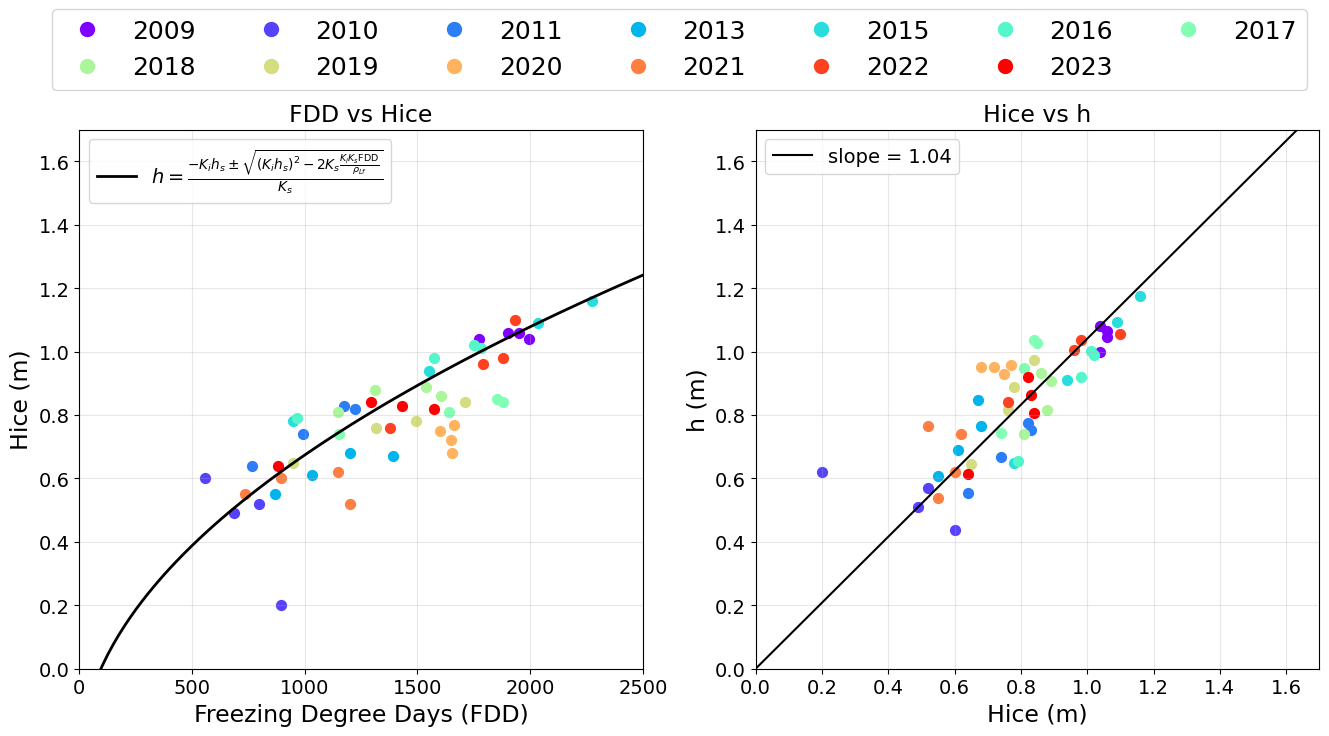

In [26]:
years = [2009, 2010, 2011, 2013, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

fdd_vars = [
    nain_2009_fdd, nain_2010_fdd, nain_2011_fdd, nain_2013_fdd,
    nain_2015_fdd, nain_2016_fdd, nain_2017_fdd, nain_2018_fdd,
    nain_2019_fdd, nain_2020_fdd, nain_2021_fdd, nain_2022_fdd, 
    nain_2023_fdd
]

h_vars = [
    nain_2009_hice, nain_2010_hice, nain_2011_hice, nain_2013_hice,
    nain_2015_hice, nain_2016_hice, nain_2017_hice, nain_2018_hice,
    nain_2019_hice, nain_2020_hice, nain_2021_hice, nain_2022_hice, 
    nain_2023_hice
]

h_vars1 = [
    nain_2009_hice1, nain_2010_hice1, nain_2011_hice1, nain_2013_hice1,
    nain_2015_hice1, nain_2016_hice1, nain_2017_hice1, nain_2018_hice1,
    nain_2019_hice1, nain_2020_hice1, nain_2021_hice1, nain_2022_hice1, 
    nain_2023_hice1
]

h_vars2 = [
    nain_2009_hice2, nain_2010_hice2, nain_2011_hice2, nain_2013_hice2,
    nain_2015_hice2, nain_2016_hice2, nain_2017_hice2, nain_2018_hice2,
    nain_2019_hice2, nain_2020_hice2, nain_2021_hice2, nain_2022_hice2, 
    nain_2023_hice2
]

hice_vars = [
    sat_2009_hice, sat_2010_hice, sat_2011_hice, sat_2013_hice,
    sat_2015_hice, sat_2016_hice, sat_2017_hice, sat_2018_hice,
    sat_2019_hice, sat_2020_hice, sat_2021_hice, sat_2022_hice, 
    sat_2023_hice
]

# Colors for each year
colors = plt.cm.rainbow(np.linspace(0, 1, len(years)))

# Increase figure size and adjust layout
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(16, 7))

# Plot for h_vars
for year, fdd, h, color in zip(years, fdd_vars, h_vars, colors):
    ax1.scatter(fdd, h, color=color, s=50)  # Increased point size
ax1.set_title('FDD vs h ')
ax1.set_ylabel('h (m)')
ax1.set_xlabel('Freezing Degree Days (FDD)')
ax1.grid(alpha=0.3)
ax1.set_xticks([500, 1000,  1500, 2000, 2500])
ax1.set_ylim(0,1.7)
ax1.set_xlim(500,2500)

# Add the formula to the first panel
formula_text = r'$h = \sqrt{\frac{2 \cdot K_i \cdot FDD}{\rho_{i} \cdot L_f}}$'
ax1.text(0.05, 0.95, formula_text, transform=ax1.transAxes, verticalalignment='top', 
         bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
ax1.text(0.03, 0.97, formula_text, transform=ax2.transAxes, verticalalignment='top', 
         bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

# Flatten the arrays
x = np.array(fdd_vars).flatten()
y = np.array(h_vars).flatten()

# Fit the data to h = a * sqrt(FDD)
# Transform FDD values to their square roots
x_sqrt = np.sqrt(x)

# Perform a linear fit between h and sqrt(FDD)
coefficients = np.polyfit(x_sqrt, y, 1)

# Define the fitted polynomial (linear in terms of sqrt(FDD))
def fitted_function(x, coefficients):
    return coefficients[0] * np.sqrt(x) + coefficients[1]


# Generate data for the fitted line
x_fit = np.linspace(0, 2500, 100)
y_fit = fitted_function(x_fit, coefficients)
ax2.plot(x_fit, y_fit, color='black', linestyle='-', linewidth=2,
         label=r"$h = \frac{-K_i h_s \pm \sqrt{(K_i h_s)^2 - 2 K_s \frac{K_i K_s \mathrm{FDD}}{\rho_{Lf}}}}{K_s}$"
)

# Add legend
ax2.legend(loc='upper left', fontsize=14)

# Plot for hice_vars
for year, fdd, hice, color in zip(years, fdd_vars, hice_vars, colors):
    ax2.scatter(fdd, hice, label=f'{year}', color=color, s=50)
    #ax2.scatter(fdd, hice, label=f'{year}', color=color, s=50)

# Set the axis limits to start from (0, 0)
ax2.set_xlim(0, None)
ax2.set_ylim(0, None)
ax2.set_title('FDD vs Hice')
ax2.set_xlabel('Freezing Degree Days (FDD)')
ax2.set_ylabel('Hice (m)')
#ax2.set_xlim(0,1.6)
ax2.set_ylim(0,1.7)
ax2.set_xlim(0,2500)
ax2.set_xticks([0, 500, 1000,  1500, 2000, 2500])
ax2.grid(alpha=0.3)

# Plot for hice_vars
for year, hice, h, color in zip(years,hice_vars,  h_vars,  colors):
    ax3.scatter(hice, h, color=color, s=50)
ax3.set_title('Hice vs h')
ax3.set_xlabel('Hice (m)')
ax3.set_ylabel('h (m)')
ax3.set_xlim(0,1.7)
ax3.set_ylim(0,1.7)
ax3.set_xticks([0,0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6])
ax3.grid(alpha=0.3)

# Combine all hice and h values for the linear regression
hice_all = np.concatenate(hice_vars)
h_all = np.concatenate(h_vars)

# Calculate the slope m for the line of best fit passing through the origin
m, _, _, _ = np.linalg.lstsq(hice_all[:, np.newaxis], h_all, rcond=None)

# Define a wider range for x to extend the line
x_extended = np.linspace(0, max(hice_all)*1.7, 100)

# Plot the extended line of best fit
ax3.plot(x_extended, m*x_extended, 'k', label=f'slope = {m[0]:.2f}')
ax3.legend(loc='upper left',fontsize=14)

ncol=7
year_handles = []
for col in range(ncol):
    for row in range(len(years) // ncol + 1):
        index = col + row * ncol
        if index < len(years):
            year_handles.append(plt.Line2D([0], [0], color=colors[index], linestyle=None,
                                           marker='o', markersize=10, lw=0, label=str(years[index])))

# Adding horizontal legend for years
year_legend = fig.legend(handles=year_handles, loc='upper center', bbox_to_anchor=(0.5, 1.07), ncol=ncol, frameon=True)

# Save and show plot
plt.tight_layout(rect=[0, 0, -0.5, 0.95])
plt.savefig('FDD_h_HICE1.jpg', dpi=500, bbox_inches='tight')
plt.show()

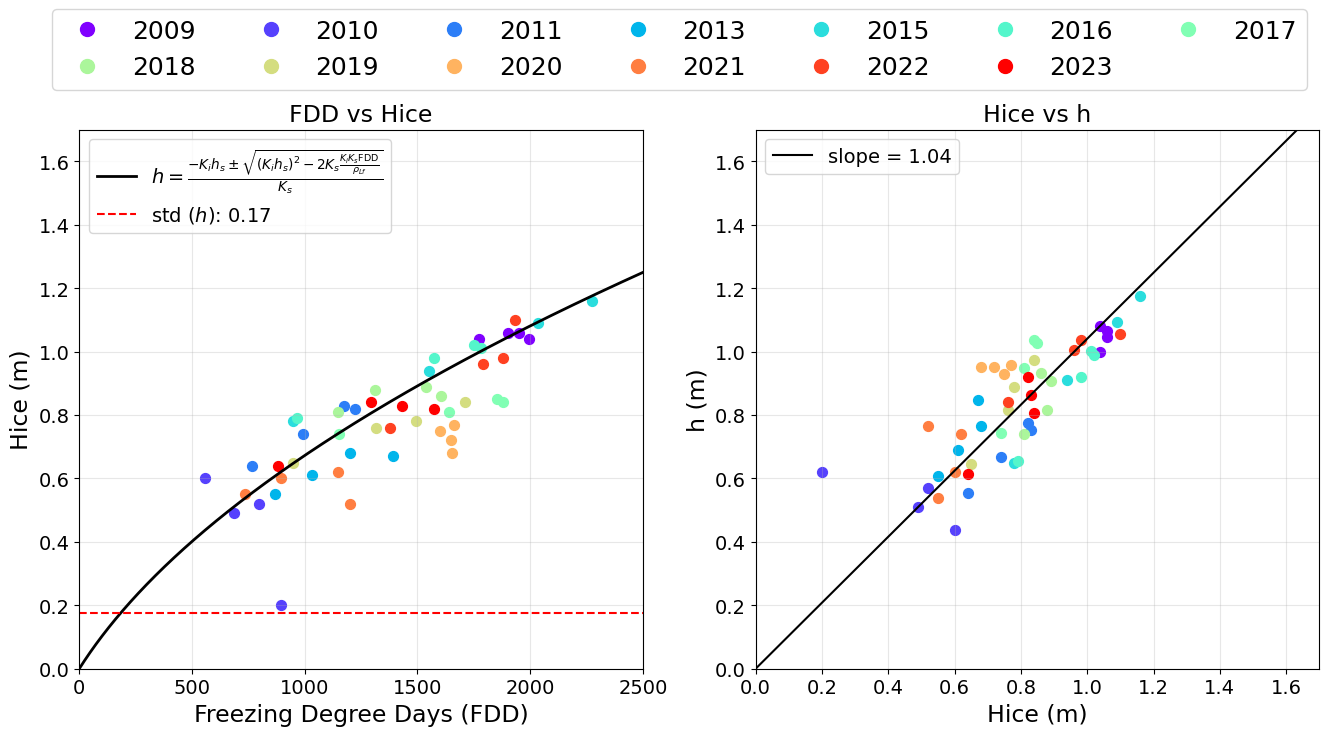

In [27]:
years = [2009, 2010, 2011, 2013, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

fdd_vars = [
    nain_2009_fdd, nain_2010_fdd, nain_2011_fdd, nain_2013_fdd,
    nain_2015_fdd, nain_2016_fdd, nain_2017_fdd, nain_2018_fdd,
    nain_2019_fdd, nain_2020_fdd, nain_2021_fdd, nain_2022_fdd, 
    nain_2023_fdd
]

h_vars = [
    nain_2009_hice, nain_2010_hice, nain_2011_hice, nain_2013_hice,
    nain_2015_hice, nain_2016_hice, nain_2017_hice, nain_2018_hice,
    nain_2019_hice, nain_2020_hice, nain_2021_hice, nain_2022_hice, 
    nain_2023_hice
]


hice_vars = [
    sat_2009_hice, sat_2010_hice, sat_2011_hice, sat_2013_hice,
    sat_2015_hice, sat_2016_hice, sat_2017_hice, sat_2018_hice,
    sat_2019_hice, sat_2020_hice, sat_2021_hice, sat_2022_hice, 
    sat_2023_hice
]

# Colors for each year
colors = plt.cm.rainbow(np.linspace(0, 1, len(years)))

# Increase figure size and adjust layout
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1
for year, fdd, hice, color in zip(years, fdd_vars, hice_vars, colors):
    ax2.scatter(fdd, hice, color=color, s=50)
ax2.set_xlim(0, None)
ax2.set_ylim(0, None)
ax2.set_title('FDD vs Hice')
ax2.set_xlabel('Freezing Degree Days (FDD)')
ax2.set_ylabel('Hice (m)')
ax2.set_ylim(0,1.7)
ax2.set_xlim(0,2500)
ax2.set_xticks([0, 500, 1000,  1500, 2000, 2500])
ax2.grid(alpha=0.3)
fdd=np.arange(0,2501)
h=h_var(fdd)
ax2.plot(fdd, h, color='black', linestyle='-', linewidth=2,
         label=r"$h = \frac{-K_i h_s \pm \sqrt{(K_i h_s)^2 - 2 K_s \frac{K_i K_s \mathrm{FDD}}{\rho_{Lf}}}}{K_s}$")
##################################
detrended_h = detrend(np.array(h_vars).flatten())
std_dev = np.std(detrended_h)
ax2.axhline(y=std_dev, color='r', linestyle='--', label=f'std ($h$): {std_dev:.2f}')


# Plot 2
for year, hice, h, color in zip(years,hice_vars,  h_vars,  colors):
    ax3.scatter(hice, h, color=color, s=50)
ax3.set_title('Hice vs h')
ax3.set_xlabel('Hice (m)')
ax3.set_ylabel('h (m)')
ax3.set_xlim(0,1.7)
ax3.set_ylim(0,1.7)
ax3.set_xticks([0,0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6])
ax3.grid(alpha=0.3)
# Combine all hice and h values for the linear regression
hice_all = np.concatenate(hice_vars)
h_all = np.concatenate(h_vars)
m, _, _, _ = np.linalg.lstsq(hice_all[:, np.newaxis], h_all, rcond=None)
x_extended = np.linspace(0, max(hice_all)*1.7, 100)
ax3.plot(x_extended, m*x_extended, 'k', label=f'slope = {m[0]:.2f}')
ax3.legend(loc='upper left',fontsize=14)
y_detrended = h_all - (m[0] * hice_all)

# Calculating the standard deviation of the detrended y
#std_detrended_y = np.std(y_detrended)
#ax2.axhline(y=std_detrended_y, color='r', linestyle='--', label=f'std (h): {std_dev:.2f}')
ax2.legend(loc='upper left', fontsize=14)



ncol=7
year_handles = []
for col in range(ncol):
    for row in range(len(years) // ncol + 1):
        index = col + row * ncol
        if index < len(years):
            year_handles.append(plt.Line2D([0], [0], color=colors[index], linestyle=None,
                                           marker='o', markersize=10, lw=0, label=str(years[index])))

# Adding horizontal legend for years
year_legend = fig.legend(handles=year_handles, loc='upper center', bbox_to_anchor=(0.5, 1.07), ncol=ncol, frameon=True)

# Save and show plot
plt.tight_layout(rect=[0, 0, -0.5, 0.95])
plt.savefig('FDD_h_HICE.jpg', dpi=500, bbox_inches='tight')
plt.show()

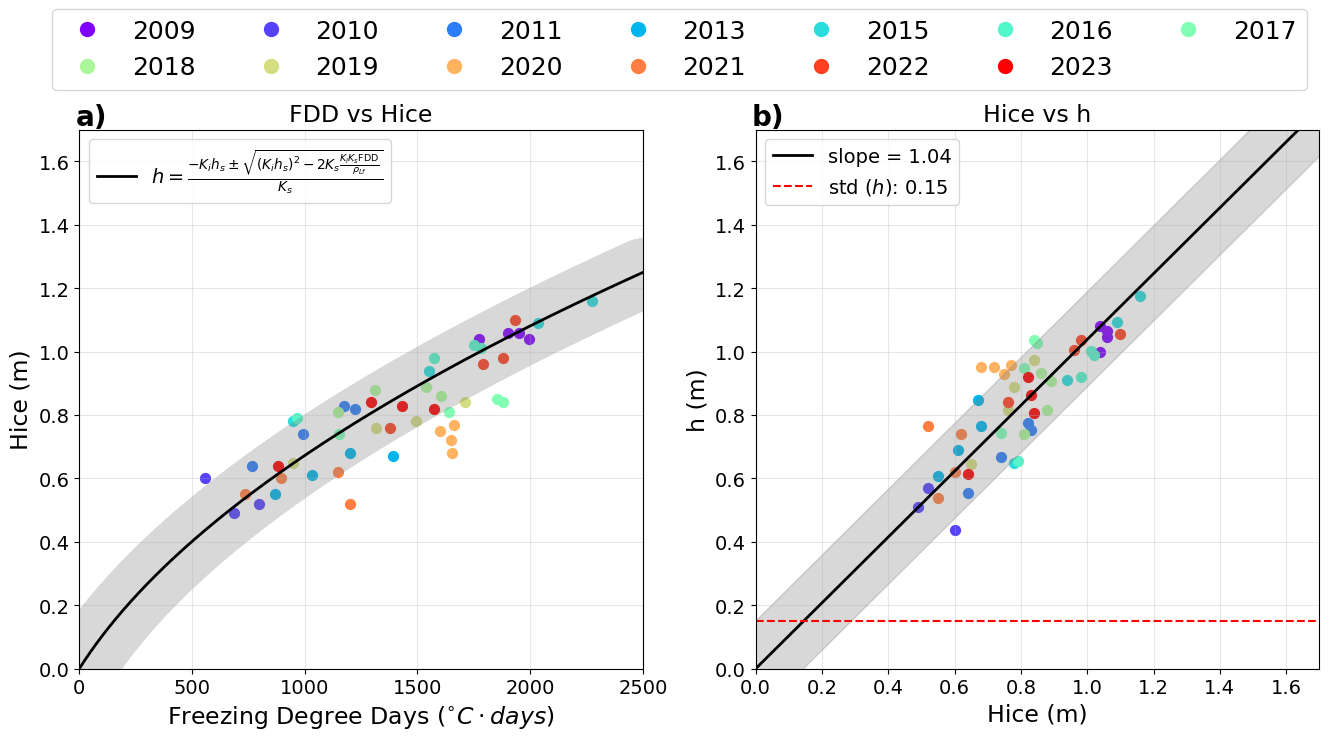

In [28]:
years = [2009, 2010, 2011, 2013, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

fdd_vars = [
    nain_2009_fdd, nain_2010_fdd[:3], nain_2011_fdd, nain_2013_fdd,
    nain_2015_fdd, nain_2016_fdd, nain_2017_fdd, nain_2018_fdd,
    nain_2019_fdd, nain_2020_fdd, nain_2021_fdd, nain_2022_fdd, 
    nain_2023_fdd
]

h_vars = [
    nain_2009_hice, nain_2010_hice[:3], nain_2011_hice, nain_2013_hice,
    nain_2015_hice, nain_2016_hice, nain_2017_hice, nain_2018_hice,
    nain_2019_hice, nain_2020_hice, nain_2021_hice, nain_2022_hice, 
    nain_2023_hice
]


hice_vars = [
    sat_2009_hice, sat_2010_hice[:3], sat_2011_hice, sat_2013_hice,
    sat_2015_hice, sat_2016_hice, sat_2017_hice, sat_2018_hice,
    sat_2019_hice, sat_2020_hice, sat_2021_hice, sat_2022_hice, 
    sat_2023_hice
]

# Colors for each year
colors = plt.cm.rainbow(np.linspace(0, 1, len(years)))

# Increase figure size and adjust layout
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1
for year, fdd, hice, color in zip(years, fdd_vars, hice_vars, colors):
    ax2.scatter(fdd, hice, color=color, s=50)
ax2.set_xlim(0, None)
ax2.set_ylim(0, None)
ax2.set_title('FDD vs Hice')
ax2.set_xlabel('Freezing Degree Days ($^{\circ} C \cdot days$)')
ax2.set_ylabel('Hice (m)')
ax2.set_ylim(0,1.7)
ax2.set_xlim(0,2500)
ax2.set_xticks([0, 500, 1000,  1500, 2000, 2500])
ax2.grid(alpha=0.3)
fdd=np.arange(0,2501)


h=h_var(fdd)
ax2.plot(fdd, h, color='black', linestyle='-', linewidth=2,
         label=r"$h = \frac{-K_i h_s \pm \sqrt{(K_i h_s)^2 - 2 K_s \frac{K_i K_s \mathrm{FDD}}{\rho_{Lf}}}}{K_s}$")

# Amplified FDD starting one week earlier (14 days earlier)
fdd_earlier = np.arange(-14, 2501)
h_earlier = h_var(fdd_earlier)[14:]  # Skip the first 14 days to align

# Amplified FDD starting one week later (14 days later)
fdd_later = np.arange(0, 2501 + 14)
h_later = h_var(fdd_later)[:-14]  # Skip the last 14 days to align

# Ensure all arrays have the same length
min_length = min(len(fdd), len(h), len(h_earlier), len(h_later))
fdd = fdd[:min_length]
h = h[:min_length]
h_earlier = h_earlier[:min_length]
h_later = h_later[:min_length]
# Plot the shaded area between the curves with increased linewidth
ax2.fill_between(fdd, h_earlier, h_later, color='gray', alpha=0.3, linewidth=50)


##################################
flat_list = [item for sublist in h_vars for item in sublist]

# Convert to a NumPy array
flat_array = np.array(flat_list)

# Apply the detrend function
detrended_h = detrend(flat_array)
std_dev = np.std(detrended_h)

# Plot 2
for year, hice, h, color in zip(years,hice_vars,  h_vars,  colors):
    ax3.scatter(hice, h, color=color, s=50)
ax3.set_title('Hice vs h')
ax3.set_xlabel('Hice (m)')
ax3.set_ylabel('h (m)')
ax3.set_xlim(0,1.7)
ax3.set_ylim(0,1.7)
ax3.set_xticks([0,0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6])
ax3.grid(alpha=0.3)
# Combine all hice and h values for the linear regression
hice_all = np.concatenate(hice_vars)
h_all = np.concatenate(h_vars)
m, _, _, _ = np.linalg.lstsq(hice_all[:, np.newaxis], h_all, rcond=None)
x_extended = np.linspace(0, max(hice_all)*1.7, 100)

std_dev = 0.15  # Example standard deviation

# Calculate the y values for the upper and lower bounds of the shaded area
y_fit = m * x_extended
y_upper = y_fit + std_dev
y_lower = y_fit - std_dev

ax3.plot(x_extended, m*x_extended, 'black', linewidth=2, label=f'slope = {m[0]:.2f}')
ax3.fill_between(x_extended, y_lower, y_upper, color='gray', alpha=0.3)
ax3.axhline(y=std_dev, color='r', linestyle='--', label=f'std ($h$): {std_dev:.2f}')
ax3.legend(loc='upper left',fontsize=14)
# Calculating the standard deviation of the detrended y
#std_detrended_y = np.std(y_detrended)
#ax2.axhline(y=std_detrended_y, color='r', linestyle='--', label=f'std (h): {std_dev:.2f}')
ax2.legend(loc='upper left', fontsize=14)





ncol=7
year_handles = []
for col in range(ncol):
    for row in range(len(years) // ncol + 1):
        index = col + row * ncol
        if index < len(years):
            year_handles.append(plt.Line2D([0], [0], color=colors[index], linestyle=None,
                                           marker='o', markersize=10, lw=0, label=str(years[index])))

# Adding horizontal legend for years
year_legend = fig.legend(handles=year_handles, loc='upper center', bbox_to_anchor=(0.5, 1.07), ncol=ncol, frameon=True)

# Add subplot label
ax2.text(0.05, 1.05, 'a)', transform=ax2.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
ax3.text(0.05, 1.05, 'b)', transform=ax3.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')



# Save and show plot
plt.tight_layout(rect=[0, 0, -0.5, 0.95])
plt.savefig('FDD_h_HICE.jpg', dpi=500, bbox_inches='tight')
plt.show()

### Calculate how many FDD was needed for each year to reach the first appearance of ice first

In [29]:
def ffd_to_onset (t2m, freezing_date, onset_date):
    t2m_sel=t2m.sel(time=slice(freezing_date,onset_date))

    #correct conversion to positive freezing degrees
    t2m_fd=t2m_sel.where(t2m_sel<0,drop=True)*-1
    
    #calculating the freezing degree days
    t2m_fdd=round(t2m_fd.sum(dim='time').values.item(), 2)
   
    
    return t2m_fdd

In [30]:
nain_2009_ffd_to_onset = ffd_to_onset(nain_t2m_daily_celsius, '2008-11-01', '2008-12-08')
nain_2010_ffd_to_onset = ffd_to_onset(nain_t2m_daily_celsius, '2009-11-01', '2009-12-21')
nain_2011_ffd_to_onset = ffd_to_onset(nain_t2m_daily_celsius, '2010-11-01', '2010-12-27')
nain_2013_ffd_to_onset = ffd_to_onset(nain_t2m_daily_celsius, '2012-11-01', '2012-12-16')
nain_2015_ffd_to_onset = ffd_to_onset(nain_t2m_daily_celsius, '2014-11-01', '2014-12-07')
nain_2016_ffd_to_onset = ffd_to_onset(nain_t2m_daily_celsius, '2015-11-01', '2015-12-19')
nain_2017_ffd_to_onset = ffd_to_onset(nain_t2m_daily_celsius, '2016-11-01', '2016-12-19')
nain_2018_ffd_to_onset = ffd_to_onset(nain_t2m_daily_celsius, '2017-11-01', '2017-12-25')
nain_2019_ffd_to_onset = ffd_to_onset(nain_t2m_daily_celsius, '2018-11-01', '2018-12-03')
nain_2020_ffd_to_onset = ffd_to_onset(nain_t2m_daily_celsius, '2019-11-01', '2019-12-16')
nain_2021_ffd_to_onset = ffd_to_onset(nain_t2m_daily_celsius, '2020-11-01', '2020-12-01')
nain_2022_ffd_to_onset = ffd_to_onset(nain_t2m_daily_celsius, '2021-11-01', '2021-12-06')
nain_2023_ffd_to_onset = ffd_to_onset(nain_t2m_daily_celsius, '2022-11-01', '2022-12-12')

In [31]:
fdd_values = {
    '2009': nain_2009_ffd_to_onset,
    '2010': nain_2010_ffd_to_onset,
    '2011': nain_2011_ffd_to_onset,
    '2013': nain_2013_ffd_to_onset,
    '2015': nain_2015_ffd_to_onset,
    '2016': nain_2016_ffd_to_onset,
    '2017': nain_2017_ffd_to_onset,
    '2018': nain_2018_ffd_to_onset,
    '2019': nain_2019_ffd_to_onset,
    '2020': nain_2020_ffd_to_onset,
    '2021': nain_2021_ffd_to_onset,
    '2022': nain_2022_ffd_to_onset,
    '2023': nain_2023_ffd_to_onset
}

# Creating the dataframe
df_fdd_to_onset = pd.DataFrame(list(fdd_values.items()), columns=['Year', 'FDD Values'])

### Calculate the number of FDD needed to go from first appearance of ice to appearance of landfast ice

In [32]:
def ffd_from_onset_to_landfast (t2m, onset_date, lastfast_first_date):
    t2m_sel=t2m.sel(time=slice(onset_date, lastfast_first_date))

    #correct conversion to positive freezing degrees
    t2m_fd=t2m_sel.where(t2m_sel<0,drop=True)*-1
    
    #calculating the freezing degree days
    t2m_fdd=round(t2m_fd.sum(dim='time').values.item(), 2)
   
    
    return t2m_fdd

In [33]:
nain_2009_ffd_from_onset_to_landfast = ffd_from_onset_to_landfast(nain_t2m_daily_celsius, '2008-12-08', '2008-12-29')
nain_2010_ffd_from_onset_to_landfast = ffd_from_onset_to_landfast(nain_t2m_daily_celsius, '2009-12-21', '2010-02-15')
nain_2011_ffd_from_onset_to_landfast = ffd_from_onset_to_landfast(nain_t2m_daily_celsius, '2010-12-27', '2011-02-14')
nain_2013_ffd_from_onset_to_landfast = ffd_from_onset_to_landfast(nain_t2m_daily_celsius, '2012-12-16', '2013-01-09')
nain_2015_ffd_from_onset_to_landfast = ffd_from_onset_to_landfast(nain_t2m_daily_celsius, '2014-12-07', '2015-01-21')
nain_2016_ffd_from_onset_to_landfast = ffd_from_onset_to_landfast(nain_t2m_daily_celsius, '2015-12-19', '2015-12-30')
nain_2017_ffd_from_onset_to_landfast = ffd_from_onset_to_landfast(nain_t2m_daily_celsius, '2016-12-19', '2017-01-05')
nain_2018_ffd_from_onset_to_landfast = ffd_from_onset_to_landfast(nain_t2m_daily_celsius, '2017-12-25', '2018-01-11')
nain_2019_ffd_from_onset_to_landfast = ffd_from_onset_to_landfast(nain_t2m_daily_celsius, '2018-12-03', '2018-12-26')
nain_2020_ffd_from_onset_to_landfast = ffd_from_onset_to_landfast(nain_t2m_daily_celsius, '2019-12-16', '2020-01-08')
nain_2021_ffd_from_onset_to_landfast = ffd_from_onset_to_landfast(nain_t2m_daily_celsius, '2020-12-01', '2020-12-31')
nain_2022_ffd_from_onset_to_landfast = ffd_from_onset_to_landfast(nain_t2m_daily_celsius, '2021-12-06', '2022-01-20')
nain_2023_ffd_from_onset_to_landfast = ffd_from_onset_to_landfast(nain_t2m_daily_celsius, '2022-12-12', '2023-01-04')

In [34]:
fdd_values = {
    '2009': nain_2009_ffd_from_onset_to_landfast,
    '2010': nain_2010_ffd_from_onset_to_landfast,
    '2011': nain_2011_ffd_from_onset_to_landfast,
    '2013': nain_2013_ffd_from_onset_to_landfast,
    '2015': nain_2015_ffd_from_onset_to_landfast,
    '2016': nain_2016_ffd_from_onset_to_landfast,
    '2017': nain_2017_ffd_from_onset_to_landfast,
    '2018': nain_2018_ffd_from_onset_to_landfast,
    '2019': nain_2019_ffd_from_onset_to_landfast,
    '2020': nain_2020_ffd_from_onset_to_landfast,
    '2021': nain_2021_ffd_from_onset_to_landfast,
    '2022': nain_2022_ffd_from_onset_to_landfast,
    '2023': nain_2023_ffd_from_onset_to_landfast
}

# Creating the dataframe
df_fdd_from_onset_to_landfast = pd.DataFrame(list(fdd_values.items()), columns=['Year', 'FDD Values'])

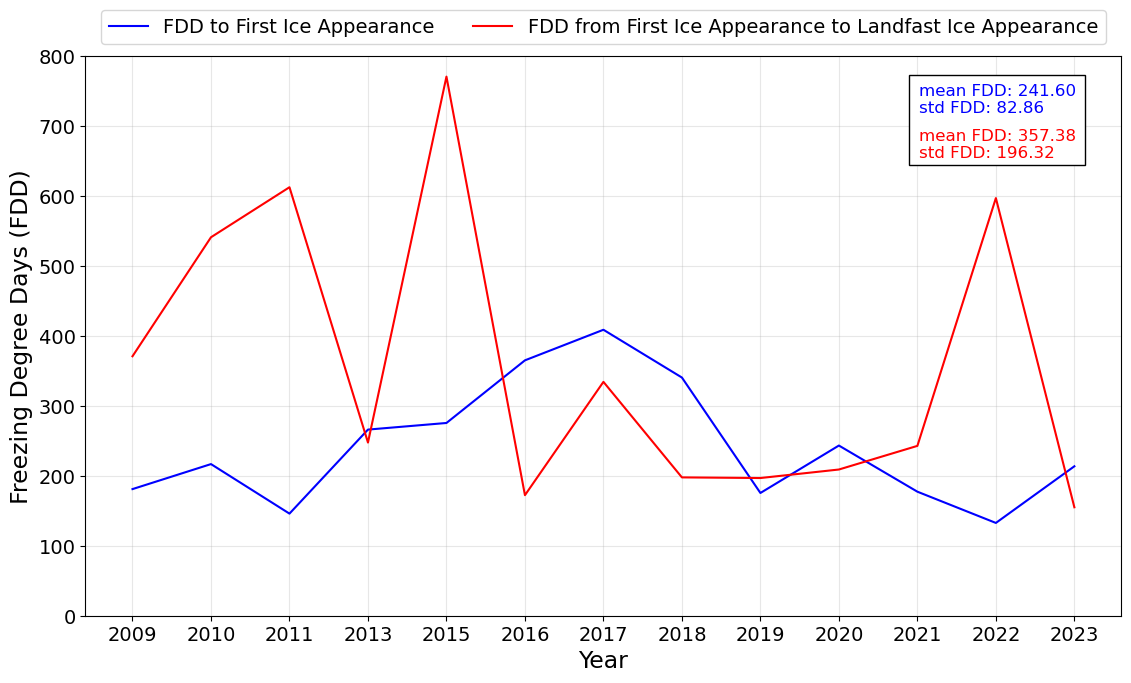

In [35]:
# Data preparation
years_to_onset = df_fdd_to_onset['Year']
fdd_to_onset = df_fdd_to_onset['FDD Values']
years_to_landfast = df_fdd_from_onset_to_landfast['Year']
fdd_to_landfast = df_fdd_from_onset_to_landfast['FDD Values']

# Calculate statistics
mean_first_ice = np.mean(fdd_to_onset)
std_first_ice = np.std(fdd_to_onset)
mean_landfast_ice = np.mean(fdd_to_landfast)
std_landfast_ice = np.std(fdd_to_landfast)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

line1,=ax.plot(years_to_onset, fdd_to_onset, label='FDD to First Ice Appearance' ,color='blue')
line2,=ax.plot(years_to_landfast, fdd_to_landfast, label='FDD from First Ice Appearance to Landfast Ice Appearance', color='red')
# Titles and labels
ax.set_xlabel('Year')
ax.set_ylabel('Freezing Degree Days (FDD)')
ax.set_ylim(0,800)
ax.grid(alpha=0.3)

# Define the position and size of the rectangle
rect_x = 0.795
rect_y = 0.805
rect_width = 0.17
rect_height = 0.16

# Create the rectangle
rect = patches.Rectangle((rect_x, rect_y), rect_width, rect_height, transform=ax.transAxes, linewidth=1, 
                         edgecolor='black',  facecolor="white", zorder=3)
ax.add_patch(rect)

# Add the text annotations within the rectangle
ax.text(0.805, 0.95, f'mean FDD: {mean_first_ice:.2f}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', color=line1.get_color())
ax.text(0.805, 0.92, f'std FDD: {std_first_ice:.2f}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', color=line1.get_color())
ax.text(0.805, 0.87, f'mean FDD: {mean_landfast_ice:.2f}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', color=line2.get_color())
ax.text(0.805, 0.84, f'std FDD: {std_landfast_ice:.2f}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', color=line2.get_color())




# Place the legend on top of the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), fontsize=14, ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjust the top margin to fit the legend
plt.savefig('onset_landfast.jpg', dpi=500, bbox_inches='tight')
plt.show()


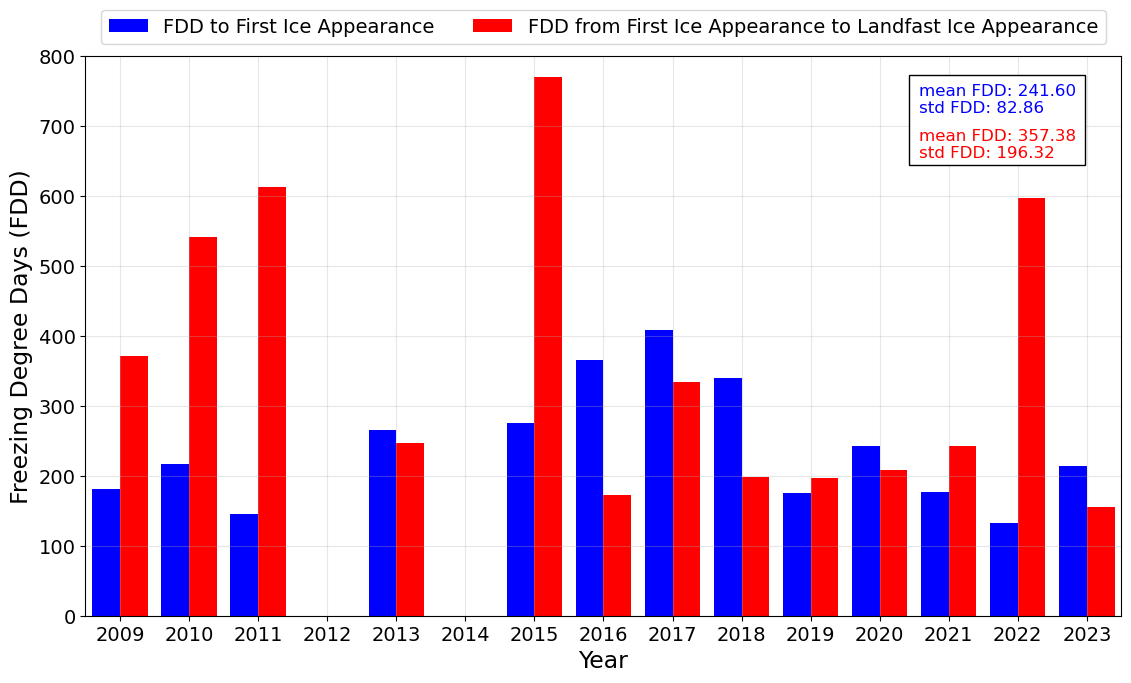

In [36]:
years_to_onset = pd.to_numeric(df_fdd_to_onset['Year'], errors='coerce')
years_to_landfast = pd.to_numeric(df_fdd_from_onset_to_landfast['Year'], errors='coerce')

# Drop any rows with NaN values that resulted from conversion
years_to_onset = years_to_onset.dropna().astype(int)
years_to_landfast = years_to_landfast.dropna().astype(int)

# Ensure the FDD values are numeric
fdd_to_onset = pd.to_numeric(df_fdd_to_onset['FDD Values'], errors='coerce')
fdd_to_landfast = pd.to_numeric(df_fdd_from_onset_to_landfast['FDD Values'], errors='coerce')

# Drop any rows with NaN values that resulted from conversion
fdd_to_onset = fdd_to_onset.dropna()
fdd_to_landfast = fdd_to_landfast.dropna()

# Calculate statistics
mean_first_ice = np.mean(fdd_to_onset)
std_first_ice = np.std(fdd_to_onset)
mean_landfast_ice = np.mean(fdd_to_landfast)
std_landfast_ice = np.std(fdd_to_landfast)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot bar charts
width = 0.4
ax.bar(years_to_onset - width/2, fdd_to_onset, width, label='FDD to First Ice Appearance', color='blue', align='center')
ax.bar(years_to_landfast + width/2, fdd_to_landfast, width, label='FDD from First Ice Appearance to Landfast Ice Appearance', color='red', align='center')

# Titles and labels
ax.set_xlabel('Year')
ax.set_ylabel('Freezing Degree Days (FDD)')
ax.set_ylim(0, 800)
ax.set_xlim(2008.5, 2023.5)
ax.set_xticks([2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])
ax.grid(alpha=0.3)

# Define the position and size of the rectangle
rect_x = 0.795
rect_y = 0.805
rect_width = 0.17
rect_height = 0.16

# Create the rectangle
rect = patches.Rectangle((rect_x, rect_y), rect_width, rect_height, transform=ax.transAxes, linewidth=1, 
                         edgecolor='black', facecolor="white", zorder=3)
ax.add_patch(rect)

# Add the text annotations within the rectangle
ax.text(0.805, 0.95, f'mean FDD: {mean_first_ice:.2f}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', color='blue')
ax.text(0.805, 0.92, f'std FDD: {std_first_ice:.2f}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', color='blue')
ax.text(0.805, 0.87, f'mean FDD: {mean_landfast_ice:.2f}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', color='red')
ax.text(0.805, 0.84, f'std FDD: {std_landfast_ice:.2f}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', color='red')

# Place the legend on top of the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), fontsize=14, ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjust the top margin to fit the legend
plt.savefig('onset_landfast.jpg', dpi=500, bbox_inches='tight')
plt.show()


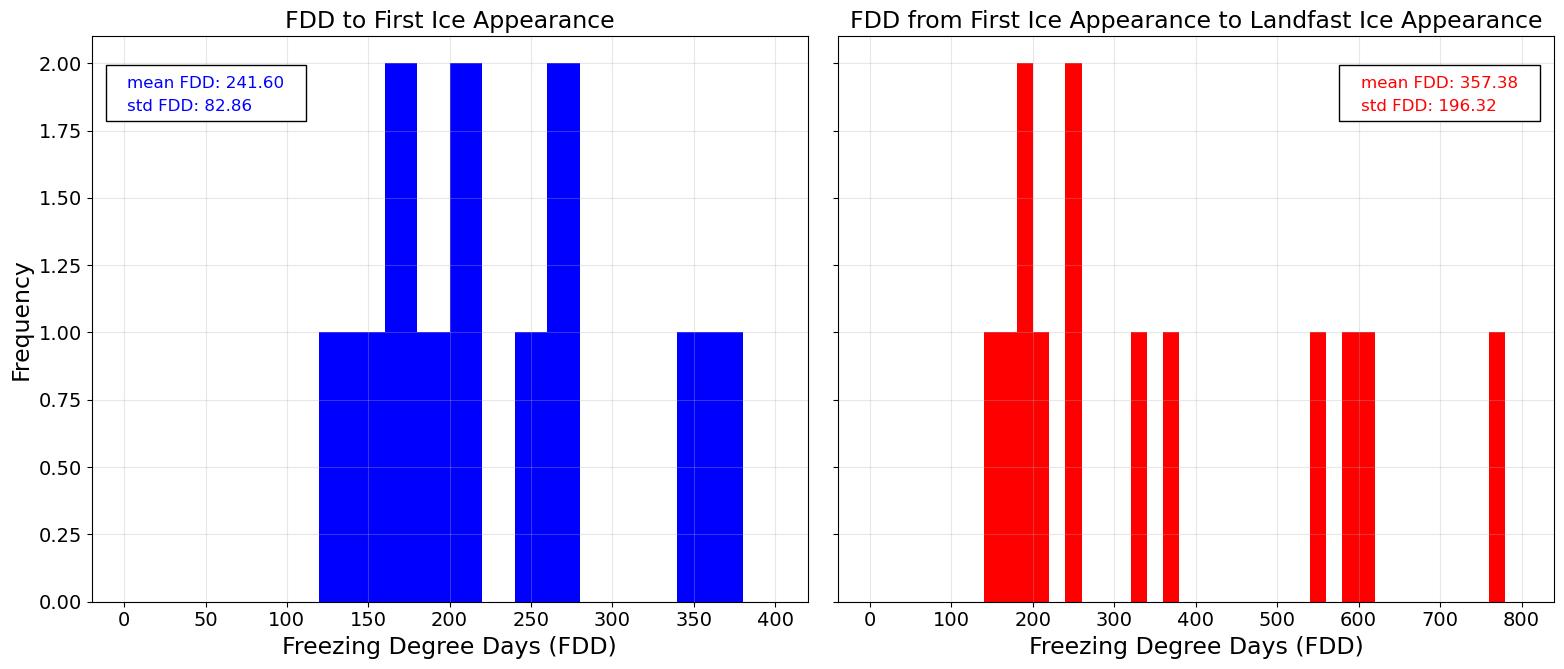

In [37]:
# Data preparation
years_to_onset = df_fdd_to_onset['Year']
fdd_to_onset = df_fdd_to_onset['FDD Values']
years_to_landfast = df_fdd_from_onset_to_landfast['Year']
fdd_to_landfast = df_fdd_from_onset_to_landfast['FDD Values']

# Calculate statistics
mean_first_ice = np.mean(fdd_to_onset)
std_first_ice = np.std(fdd_to_onset)
mean_landfast_ice = np.mean(fdd_to_landfast)
std_landfast_ice = np.std(fdd_to_landfast)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

# Plot histograms
ax1.hist(fdd_to_onset, bins=np.arange(100, 400 + 20, 20), color='blue')
ax2.hist(fdd_to_landfast, bins=np.arange(100, 800 + 20, 20), color='red')

# Titles and labels for ax1
ax1.set_xlabel('Freezing Degree Days (FDD)')
ax1.set_ylabel('Frequency')
ax1.set_title('FDD to First Ice Appearance')
ax1.grid(alpha=0.3)

# Titles and labels for ax2
ax2.set_xlabel('Freezing Degree Days (FDD)')
#ax2.set_ylabel('Frequency')
ax2.set_title('FDD from First Ice Appearance to Landfast Ice Appearance')
ax2.grid(alpha=0.3)


rect_x = 0.02
rect_y = 0.85
rect_width = 0.28
rect_height = 0.1

# Create the rectangle
rect1 = patches.Rectangle((rect_x, rect_y), rect_width, rect_height, transform=ax1.transAxes, linewidth=1, 
                         edgecolor='black', facecolor="white", zorder=3)
ax1.add_patch(rect1)


rect_x2 = 0.7
rect_y2 = 0.85
# Create the rectangle
rect2 = patches.Rectangle((rect_x2, rect_y2), rect_width, rect_height, transform=ax2.transAxes, linewidth=1, 
                         edgecolor='black', facecolor="white", zorder=3)
ax2.add_patch(rect2)


# Add statistical annotations
ax1.text(0.05, 0.93, f'mean FDD: {mean_first_ice:.2f}', transform=ax1.transAxes, fontsize=12,
         verticalalignment='top', color='blue')
ax1.text(0.05, 0.89, f'std FDD: {std_first_ice:.2f}', transform=ax1.transAxes, fontsize=12,
         verticalalignment='top', color='blue')

ax2.text(0.73, 0.93, f'mean FDD: {mean_landfast_ice:.2f}', transform=ax2.transAxes, fontsize=12,
         verticalalignment='top', color='red')
ax2.text(0.73, 0.89, f'std FDD: {std_landfast_ice:.2f}', transform=ax2.transAxes, fontsize=12,
         verticalalignment='top', color='red')

plt.tight_layout()
plt.savefig('onset_landfast.jpg', dpi=500, bbox_inches='tight')
plt.show()

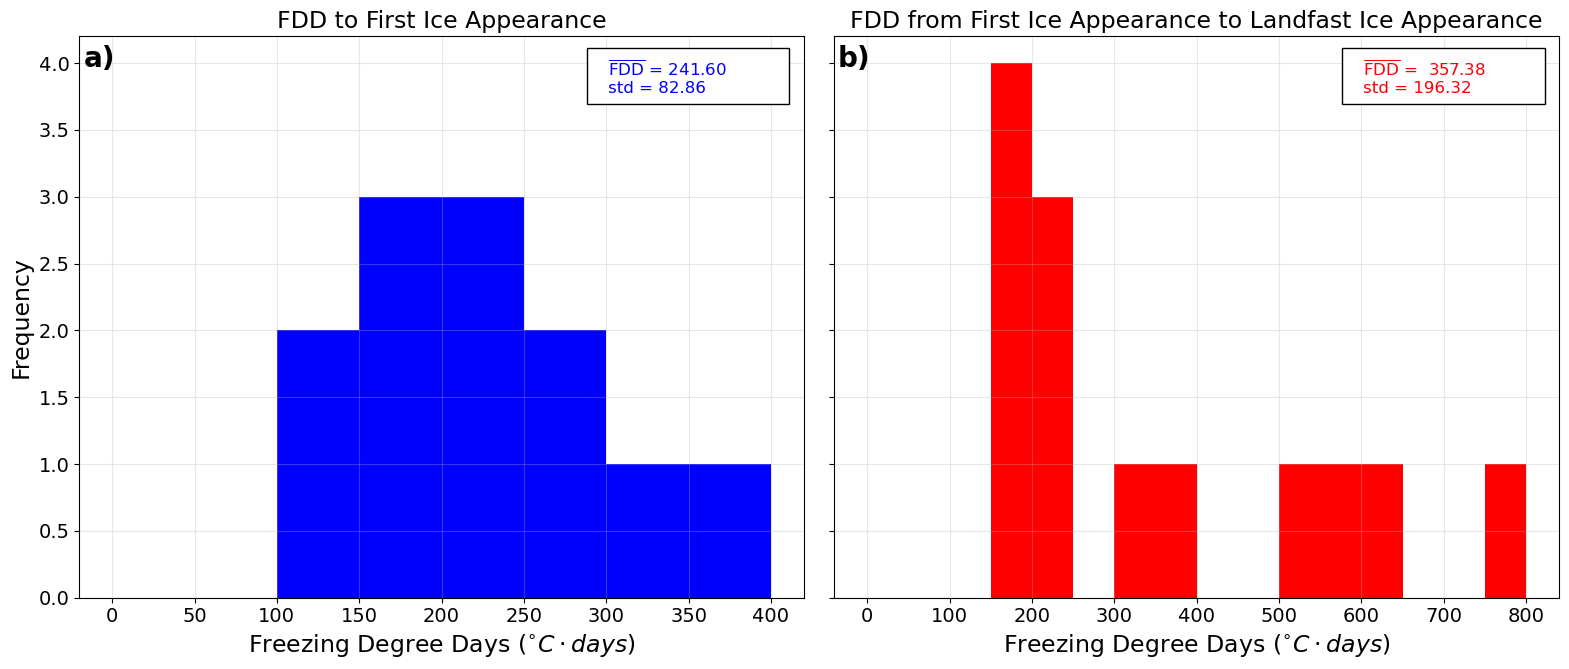

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Data preparation
years_to_onset = df_fdd_to_onset['Year']
fdd_to_onset = df_fdd_to_onset['FDD Values']
years_to_landfast = df_fdd_from_onset_to_landfast['Year']
fdd_to_landfast = df_fdd_from_onset_to_landfast['FDD Values']

# Calculate statistics
mean_first_ice = np.mean(fdd_to_onset)
std_first_ice = np.std(fdd_to_onset)
mean_landfast_ice = np.mean(fdd_to_landfast)
std_landfast_ice = np.std(fdd_to_landfast)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

# Plot histograms
ax1.hist(fdd_to_onset, bins=np.arange(0, 400 + 50, 50), color='blue')
ax2.hist(fdd_to_landfast, bins=np.arange(0, 800 + 50, 50), color='red')

# Titles and labels for ax1
ax1.set_xlabel('Freezing Degree Days ($^{\circ} C \cdot days$)')
ax1.set_ylabel('Frequency')
ax1.set_title('FDD to First Ice Appearance')
ax1.grid(alpha=0.3)

# Titles and labels for ax2
ax2.set_xlabel('Freezing Degree Days ($^{\circ} C \cdot days$)')
# ax2.set_ylabel('Frequency')
ax2.set_title('FDD from First Ice Appearance to Landfast Ice Appearance')
ax2.grid(alpha=0.3)

rect_x = 0.7
rect_y = 0.88
rect_width = 0.28
rect_height = 0.1

# Create the rectangle
rect1 = patches.Rectangle((rect_x, rect_y), rect_width, rect_height, transform=ax1.transAxes, linewidth=1, 
                         edgecolor='black', facecolor="white", zorder=3)
ax1.add_patch(rect1)

rect_x2 = 0.7
rect_y2 = 0.88
# Create the rectangle
rect2 = patches.Rectangle((rect_x2, rect_y2), rect_width, rect_height, transform=ax2.transAxes, linewidth=1, 
                         edgecolor='black', facecolor="white", zorder=3)
ax2.add_patch(rect2)

# Add statistical annotations
ax1.text(0.73, 0.96, f'$\overline{{\\mathrm{{FDD}}}}$ = {mean_first_ice:.2f}', transform=ax1.transAxes, fontsize=12,
         verticalalignment='top', color='blue')
ax1.text(0.73, 0.92, f'std = {std_first_ice:.2f}', transform=ax1.transAxes, fontsize=12,
         verticalalignment='top', color='blue')

ax2.text(0.73, 0.96, f'$\overline{{\\mathrm{{FDD}}}}$ =  {mean_landfast_ice:.2f}', transform=ax2.transAxes, fontsize=12,
         verticalalignment='top', color='red')
ax2.text(0.73, 0.92, f'std = {std_landfast_ice:.2f}', transform=ax2.transAxes, fontsize=12,
         verticalalignment='top', color='red')

# Add subplot label
ax1.text(0.05, 0.985, 'a)', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
ax2.text(0.05, 0.985, 'b)', transform=ax2.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')


plt.tight_layout()
plt.savefig('onset_landfast.jpg', dpi=500, bbox_inches='tight')
plt.show()


In [39]:
import numpy as np
import matplotlib.pyplot as plt


# Add labels and legend
ax.set_xlabel('Freezing Degree Days (FDD)')
ax.set_ylabel('Ice Thickness (h)')
ax.legend()

# Show the plot
plt.show()


In [42]:
path='/Users/thomas/Downloads/TSA'

In [43]:
glob1=glob.glob(path+'/b.*.nc')
files=sorted(glob1)

In [45]:
data=xr.open_mfdataset(files)

In [46]:
data_TSA=data['TSA']

In [51]:
lon_min, lon_max =280, 320 #73W & 45W
lat_min, lat_max =50,70


# Create a mask for Labrador coast 
mask = ((data_TSA.lat >= lat_min) & (data_TSA.lat <= lat_max) &
        (data_TSA.lon >= lon_min) & (data_TSA.lon <= lon_max))



# Apply the mask to the aice variable
data_TSA_region_ =data_TSA.where(mask, drop=True)

In [ ]:
data_TSA_region_.to_netcdf('TSA_nunatsiavut')